# Сжатие JPEG

Все вы встречались с изображениями в формате JPEG. Благодаря сжатию они обычно занимают значительно меньше места, чем несжатые форматы типа BMP, но за это приходится платить потерей качества (хотя часто незначительной). Как же это работает?

![JPEG](https://imgur.com/YfZ2SX6.jpg)

Оказывается, в основе сжатия JPEG лежит линейная алгебра. В этой задаче мы не будем излишне вдаваться в детали кодирования файлов JPEG и ограничимся только чёрно-белыми изображениями, но рассмотренные нами принципы применяются и к цветным картинкам и, более того, ко многим другим форматам сжатия, включая видео. 

*Техническое напоминание.* Для создания матрицы нулей размера `m` на `n` используйте `np.zeros(shape=[m,n])`. Используйте код `A[i]+=42*A[j]`, чтобы прибавить к i-й строке матрицы `A` j-ю строку, умноженную на число 42. Для обмена i-й и j-й строк матрицы `A` используйте код `A[[i,j]]=A[[j,i]]`, но не `[A[i],A[j]]=[A[j],A[i]]` — этот код некорректен по некоторым нетривиальным техническим причинам. Для сравнения `x` с нулём вместо `x==0` пишите `abs(x)<1e-9`. Если возникнет необходимость решения системы линейных уравнений, рекомендуем использовать `np.linalg.solve` ([см. примеры использования](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.solve.html)) или что-то аналогичное, а не писать решение самостоятельно.

**1. Линейная независимость.**  Допишите функцию, которая возвращает `True`, если строки поданной ей на вход квадратной $n\times n$ матрицы линейно независимы, и возвращает `False` в противном случае. *Предостережение:* функция `np.linalg.solve(A,b)` едва ли поможет в решении, потому что, несмотря на написанное в документации, она не всегда выбрасывает исключение при линейной зависимости строк `A`; для примера попробуйте $A = \scriptsize\begin{pmatrix}1 & 2 & 3 \\ 4 & 5 & 6 \\ 7 & 8 & 9 \end{pmatrix}$ — строки этой матрицы линейно зависимы (видите ли вы это?).

In [68]:
def nxn_rows_independent(A):
    '''Проверка линейной независимости строк nxn матрицы A'''
    A = A.copy()   # создать копию A, которую можно модифицировать
    n = len(A)
    for i in range(n - 1):
        if all(A[i, x] == 0 for x in range(n)): 
            return False
        for j in range(i + 1, n):
            if A[i, i] == 0:
                rowWithNoZero = GetRowWithNoZero(A,i,i)
                if rowWithNoZero == -1:
                    return False
                A[[i, rowWithNoZero]] = A[[rowWithNoZero, i]]
            A[j] += (A[i] * (-A[j, i] / A[i, i]))
    if all(A[n - 1, x] == 0 for x in range(n)):
        return False
    return True

def GetRowWithNoZero(A, i, j):
    for k in range(j,len(A)):
        if(A[i,k]) != 0:
            return k
    return -1

**2. Кодирование блоков 8х8.** Каждый пиксель сжимаемого в JPEG чёрно-белого изображения представляется целым числом от -128 до 127, задающим градацию серого от чисто чёрного (-128) до белого (127). Изображение разбивается на квадраты размера 8 на 8 и каждый квадрат кодируется отдельно. Для простоты положим, что высота и ширина картинки делятся на 8 (если это не так, то добавляются «невидимые» строки и столбцы справа и снизу — но мы не хотим вдаваться в эти технические детали). Иллюстрация разбиения:

![Разбиение на клетки 8x8](https://imgur.com/qNZQAQP.jpg)

Для $u, v \in \{0,1,\ldots,7\}$ обозначим через $B_{u,v}$ матрицу 8x8, в которой для $x, y \in \{0,1,\ldots,7\}$ элемент в $(x{+}1)$-й строке и $(y{+}1)$-м столбце равен числу $\cos(\frac{(2x + 1)u\pi}{16})\cos(\frac{(2y + 1)v\pi}{16})$. Сопоставим матрице $127\cdot B_{u,v}$ изображение 8 на 8 с пикселями цвета $127\cos(\frac{(2x + 1)u\pi}{16})\cos(\frac{(2y + 1)v\pi}{16})$ в $(x{+}1)$-й строке и $(y{+}1)$-м столбце (позволив дробные цвета). Полученные 64 изображения проиллюстрированы слева (изображение для $127\cdot B_{u,v}$ находится в $(u{+}1)$-й строке и $(v{+}1)$-м столбце); справа изображены увеличеные и сглаженные для красоты $127\cdot B_{1,2}$, $127\cdot B_{4,2}$ и $127\cdot B_{7,6}$:

![Базовые картинки](https://imgur.com/0CNmvYP.png)

Человеческий глаз плохо различает незначительные изменения в цвете, поэтому $60\cdot B_{7,6}$ и $66\cdot B_{7,6}$ визуально сильно похожи. Мысль сжатия JPEG в том, чтобы каждый блок 8х8 в изображении представить в виде линейной комбинации матриц $B_{u,v}$ и хранить в JPEG файле только коэффициенты этой комбинации, предварительно «огрубив» их (например, огрубив коэффициенты комбинации $66.012\cdot B_{7,6} + 53.85\cdot B_{1,2}$ до ближайшего кратного десяти, получим $70\cdot B_{7,6} + 50\cdot B_{1,2}$); кодирование устроено так, что чем сильнее огрублён коэффициент, тем меньше битов требуется для его кодирования (детали кодирования опустим). При отображении JPEG на экране каждый закодированный 8х8 блок (приближённо) восстанавливается по сохранённым 64-м коэффициентам, как линейная комбинация матриц $B_{u,v}$.

Каждую ли 8x8 матрицу можно представить линейной комбинацией матриц $\{B_{u,v}\}_{u,v \in \{0,\ldots,7\}}$? Конечно, можно математически доказать, что это так, но мы просим вас написать программу на все случаи. Действительно, может быть есть другие матрицы,  лучше чем $B_{u,v}$ отражающие восприятие человека? Оказывается, да есть. JPEG старый формат, с тех пор были найдены другие семейства матриц, лёгшие в основу форматов JPEG2000, HEVC, BPG и др. Допишите функцию, которая возвращает `True`, если каждую 8х8 матрицу можно представить линейной комбинацией из 64-х заданных 8х8 матриц `Bs[0]`, ..., `Bs[63]`, и `False` в противном случае.

In [69]:
def is_8x8_coder(Bs):
    '''Проверить, что комбинации a0*Bs[0] +...+ a63*Bs[63] дают все 8х8 матрицы'''
    matrix = np.zeros([64, 64])
    
    for number_matrix_line in range(64):
        for i in range(8):
            for j in range(8):
                matrix[number_matrix_line][8*i+j] = Bs[number_matrix_line][i][j]
                
    return nxn_rows_independent(matrix)

**3. Разложение клеток 8x8.** Допишите функцию, которая представляет данную 8х8 матрицу `C` в виде линейной комбинации заданных 8х8 матриц `Bs[0]`, ..., `Bs[63]`, т.е. возвращает список чисел `a`, такой что `C = a[0]*Bs[0] + ... + a[63]*Bs[63]`; полагайте, что это всегда возможно.


In [70]:
def encode_8x8(C, Bs):
    '''Представить 8х8 матрицу C линейной комбинацией матриц Bs[0],...,Bs[63]'''
    a = np.array([0.0] * 64)
    matrix = np.zeros([64, 64])
    
    for number_matrix_column in range(64):
        for i in range(8):
            for j in range(8):
                matrix[8*i+j][number_matrix_column] = Bs[number_matrix_column][i][j]
                
    for i in range(8):
            for j in range(8):
                a[8*i+j] = C[i][j]
    
    return np.linalg.solve(matrix, a)

**4. Обратная матрица.**  При написании функции `encode_8x8` вам, скорее всего, пришлось решать некоторую систему линейных уравнений вида $Ax = b$ для какой-то матрицы $A \in \mathbb{R}^{n\times n}$, столбца $b \in \mathbb{R}^n$ и столбца неизвестных $x$, который нужно найти. При создании JPEG изображения функция `encode_8x8` вызывается много раз (для каждого блока 8x8) и, таким образом, много раз решается система $Ax = b$ для одной и той же матрицы $A$, но разных столбцов $b$. Это довольно медленно. Для ускорения работы `encode_8x8` вместо того чтобы для каждого $b$ решать систему $Ax = b$ с помощью `np.linalg.solve`, можно один раз по $n\times n$ матрице $A$ найти такую $n\times n$ матрицу $D$ (называемую *обратной матрицей*, обозначается $A^{-1}$), что для любого $b \in \mathbb{R}^n$ решением системы $Ax = b$ является $x = Db$. Допишите функцию `inverse_matrix`, которая по $A$ получает $D$ (функцию `encode_8x8` менять не надо). Для простоты полагайте, что такая матрица $D$ всегда существует (вообще говоря, не для всех $A$ это так). В учебных целях вам запрещено пользоваться функцией `np.linalg.inv`. Подсказка: воспользуйтесь `np.linalg.solve`.

In [71]:
def inverse_matrix(A):
    '''Вернуть матрицу, обратную nxn матрице A'''
    n = len(A)
    D = np.eye(n)  # единичная матрица: на главной диагонали единицы, остальные нули
    
    return np.linalg.solve(A, D)

## Тесты
Осталось проверить, проходят ли ваши решения первоначальное тестирование. Выполните весь код (Cell -> Run All или Runtime -> Run All или другим способом, работающим в вашей среде) и посмотрите вердикт внизу страницы. Для демонстрации работы подзадачи 3 выводится некоторое несжатое изобрежание (уменьшенное), затем оно же сжатое JPEG и затем изображение, которое получилось бы из него, если использовать вашу функцию `encode_8x8` для сжатия JPEG; сравните два последних изображения (особенно небо) — артефакты сжатия на них должны быть почти идентичны. В тестирующем коде разбираться не нужно!

**Интересная информация.** Как уже обсуждалось, коэффициенты, возвращаемые `encode_8x8`, перед записью в JPEG файл «огрубляются» для достижения сжатия. Чем сильнее огрубление, тем выше сжатие, но заметнее потеря качества. Оказывается, коэффициенты при разных $B_{u,v}$ нужно огрублять по-разному. Дело в том, что человеческий глаз плохо различает изменения в мелких, подобных шуму, деталях, поэтому $99\cdot B_{7,6}$ и $66\cdot B_{7,6}$ визуально сильно похожи, но хорошо видит изменения в цвете в плавных переходах, поэтому $99\cdot B_{1,2}$ и $66\cdot B_{1,2}$ уже визуально заметно отличаются (смотрите выше в подзадаче 2, как выглядят $127\cdot B_{1,2}$ и $127\cdot B_{7,6}$). Чтобы регулировать огрубление, в JPEG хранится (обычно один на весь файл) список целых чисел `Q[0]`, ..., `Q[63]`, называемый таблицей квантизации. Пусть для заданного 8х8 блока `C` функция `encode_8x8` возвращает коэффициенты `a[0]`, ..., `a[63]`; тогда `a[i]` округляется до ближайшего кратного `Q[i]`, т.е. преобразуется в `round(a[i]/Q[i])*Q[i]`, а в JPEG файле реально хранится только число `round(a[i]/Q[i])`. Стандарт JPEG опытным путём установил рекомендуемые таблицы квантизации для допустимой потери качества (10%, 30%, 50%, ...), но можно использовать свои таблицы. Код огрубления приведён ниже; он неинтересен, поэтому мы не стали вас просить писать его.

In [72]:
def quantize(coefficients, Q):
    return [round(c / q) * q for c, q in zip(coefficients, Q)]

Этот код используется в тестах в функции `compressed_image` для генерации изображения «как бы сжатого JPEG».

Первое задание прошло все тесты
Второе задание прошло все тесты
Третье задание прошло все тесты
Четвёртое задание прошло все тесты
Изображения 1) несжатое, 2) оно же сжатое JPEG, 3) сжатие JPEG с помощью encode_8x8:


C:\Users\Илья\AppData\Local\Temp\ipykernel_18496\3238240306.py:44: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread('https://imgur.com/8VHfDfV.png')
C:\Users\Илья\AppData\Local\Temp\ipykernel_18496\3238240306.py:48: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  plt.imshow(imageio.imread('https://imgur.com/r99pKvd.jpg'), cmap='gray')


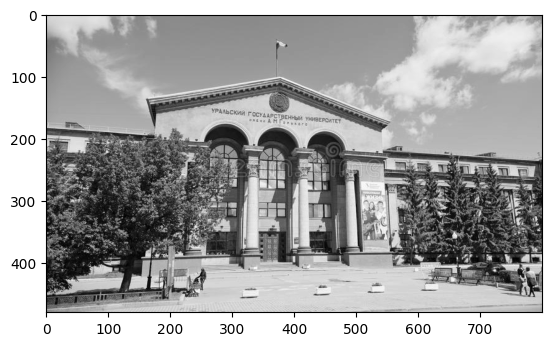

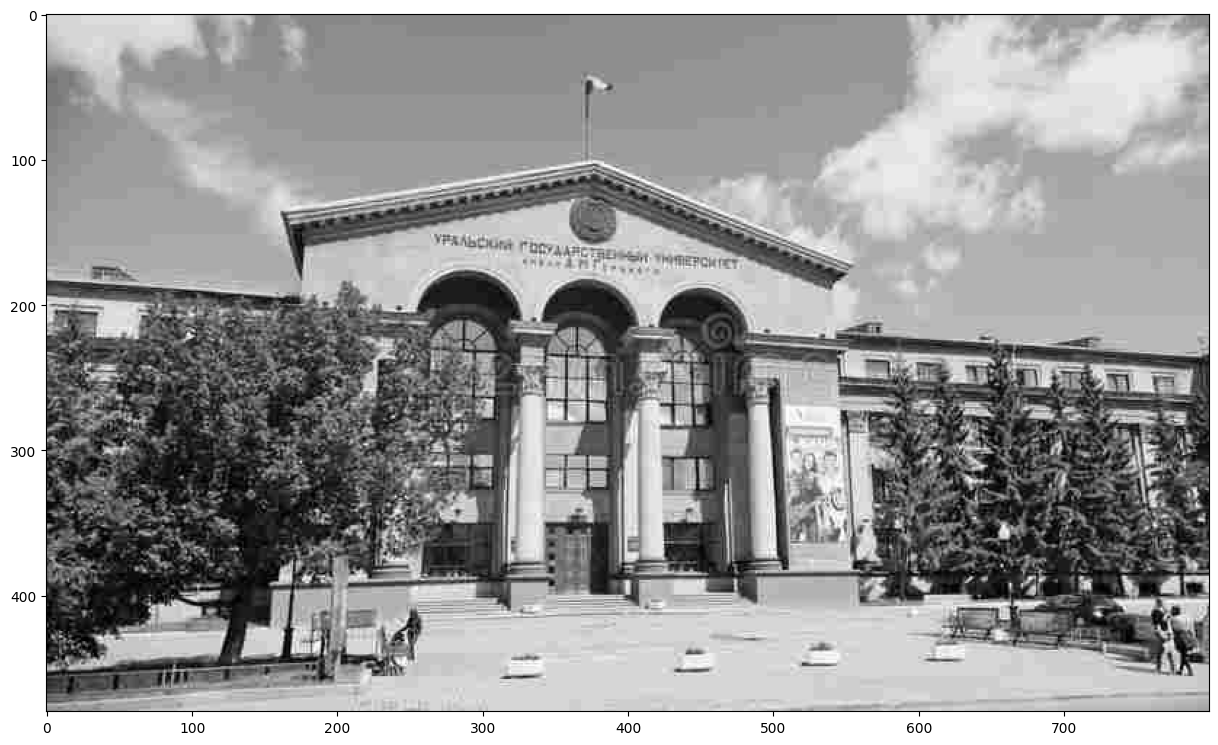

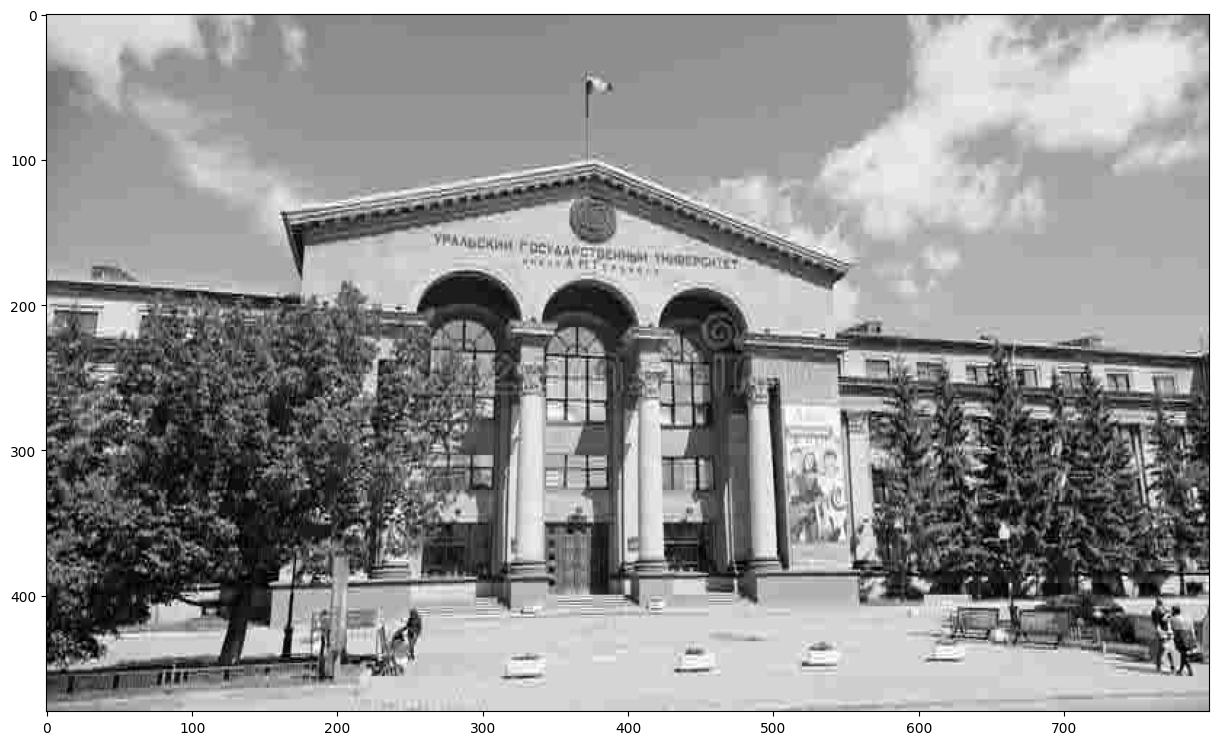

In [73]:
try:
    import numpy as np, matplotlib.pyplot as plt
    import imageio, math, itertools
except ImportError:
    !pip3 install imageio matplotlib
    import numpy as np, matplotlib.pyplot as plt
    import imageio, math, itertools
%matplotlib inline

# По техническим причинам JPEG на самом деле использует не матрицы Buv, а 
# 0.25*a(u)*a(v)*Buv, где a(w)=1, если w!=0, и a(w)=1/2**0.5, если w==0
def get_64_cosine_matrices():
    Bs = []
    for u, v in itertools.product(range(8), repeat=2):
        B = np.zeros(shape = [8, 8])
        for x, y in itertools.product(range(8), repeat=2):
            B[x, y] = math.cos((2*x + 1) * u * math.pi / 16) * math.cos((2*y + 1) * v * math.pi / 16)
            alpha1 = 1 / math.sqrt(2) if u == 0 else 1
            alpha2 = 1 / math.sqrt(2) if v == 0 else 1
            B[x, y] *= alpha1 * alpha2 * 0.25
        Bs.append(B)
    return Bs

def compressed_image(img, quantizationTable):
    Bs = get_64_cosine_matrices()
    res = img.astype(float)
    for a in range(0, res.shape[0], 8):
        for b in range(0, res.shape[1], 8):
            coef = encode_8x8(res[a:a+8, b:b+8] - 128, Bs)
            coef = quantize(coef, quantizationTable)
            res[a:a+8, b:b+8] = sum(c * B for c, B in zip(coef, Bs)) + 128
    return np.minimum(np.full(res.shape, 255), np.maximum(np.zeros(res.shape), res)).astype(int)

def show_three_images():
    quantizationTable14 = [ 57,39,43,50,43,36,57,50, # одна из стандартных сильно сжимающих таблиц
                            46,50,64,61,57,68,86,143,
                            93,86,79,79,86,175,125,132,
                            104,143,207,182,218,214,203,182,
                            200,196,228,255,255,255,228,243,
                            255,246,196,200,255,255,255,255,
                            255,255,255,255,255,221,255,255,
                            255,255,255,255,255,255,255,255 ]
    print('Изображения 1) несжатое, 2) оно же сжатое JPEG, 3) сжатие JPEG с помощью encode_8x8:')
    img = imageio.imread('https://imgur.com/8VHfDfV.png')
    plt.figure()
    plt.imshow(img, cmap='gray')
    plt.figure(figsize = [15, 15])
    plt.imshow(imageio.imread('https://imgur.com/r99pKvd.jpg'), cmap='gray')
    plt.figure(figsize = [15, 15])
    plt.imshow(compressed_image(img, quantizationTable14), cmap='gray')

def test_all():
    pos_tests = ([[-2]], [[0,1], [1,0]], [[0, 1, 2], [1, -2, 0], [0.5, 1, 2]], )
    neg_tests = ([[0]], [[-1,2], [3,-6]], [[0, 1, 2], [1, -2, 0], [0.5, 0, 2]], )
    succ = True
    for test in pos_tests:
        if succ and not nxn_rows_independent(np.array(test, dtype=float)):
            print('Первое задание не прошло тест (должно быть True):')
            print('A:', np.array(test, dtype=float))
            succ = False
    for test in neg_tests:
        if succ and nxn_rows_independent(np.array(test, dtype=float)):
            print('Первое задание не прошло тест (должно быть False):')
            print('A:', np.array(test, dtype=float))
            succ = False
    if succ:
        print('Первое задание прошло все тесты')
        
    Bs = get_64_cosine_matrices()
    Ones = []
    for i,j in itertools.product(range(8), repeat=2):
        matrix = np.zeros(shape=[8,8], dtype=float)
        matrix[i,j] = 1
        Ones.append(matrix)
    coders = (Ones, Bs, )
    non_coders = ([np.zeros(shape=[8,8])]*64, [np.zeros(shape=[8,8])] + Ones[1:], Bs[0:-1] + [Bs[2]], )
    succ = True
    for test in coders:
        if succ and not is_8x8_coder(test):
            print('Второе задание не прошло тест (должно быть True):')
            print('Bs:', 'единицы' if abs(test[0][0,0]-1) < 1e-9 else 'косинусы')
            succ = False
    for test in non_coders:
        if succ and is_8x8_coder(test):
            print('Второе задание не прошло тест (должно быть False):')
            print('Bs:', test)
            succ = False
    if succ:
        print('Второе задание прошло все тесты')
        
    coordinates = ([0]*64, [0,0,0,1] + [0]*60, [0,0,2,0.5,-0.033,0,0,4] + [0]*56, [42]*64, )
    succ = True
    for Ms, test in itertools.product([Ones, Bs], [np.array(x, dtype=float) for x in coordinates]):
        C = sum(c*B for c,B in zip(test, Ms))
        got = encode_8x8(C, Ms)
        if np.linalg.norm(got - test) >= 1e-9:
            print('Третье задание не прошло тест:')
            print('Должно быть:', test)
            print('Получено:', got)
            print('C:', C)
            print('Bs:', ('единицы' if abs(Ms[0][0,0]-1) < 1e-9 else 'косинусы'))
            succ = False
            break
    if succ:
        print('Третье задание прошло все тесты')
    
    succ = True
    matrices = (np.eye(4), [[0,0,1], [0,1,0], [1,0,0]], [[2, -4], [-1.5, 0]], [[0,1,2], [-1,2,4], [3,2,2]], )
    for A in matrices:
        A = np.array(A, dtype=float)
        if succ and np.linalg.norm(A @ inverse_matrix(A) - np.eye(A.shape[0])) >= 1e-9:
            print('Четвёртое задание не прошло тест:')
            print('A:', A)
            succ = False
    if succ:
        print('Четвёртое задание прошло все тесты')
        
    show_three_images()
    
test_all()

